# Advanced AI for Business Applications 
## Finite Markov Decision Process

#### Resources and references from MSBA 6461, Spring 2024, Mochen Yang   
Professor's GitHub link: https://github.com/mochenyang/MSBA6460-Advanced-AI.git

# Table of Contents
1. [What is Markov Decision Process (MDP)?](#intro)
    - [Definition and Notations of MDP](#definition)
    - [An Example: The Grid](#example)
1. [Solving MDP: Action-Value Methods](#solution_action_value)
    - [Policy Iteration](#policy_iteration)
        - [Policy Evaluation](#policy_evaluation)
        - [Policy Improvement](#policy_improvement)
    - [Value Iteration](#value_iteration)
    - [Monte Carlo Method](#monte_carlo)
        - [Reflections on Policy Iteration and Value Iteration](#reflection)
        - [Basic Ideas of Monte Carlo Methods](#monte_carlo_idea)
        - [Monte Carlo with Exploring Starts (Monte Carlo ES)](#MCES)
        - [epsilon-Greedy Monte Carlo](#MC_on_policy)
        - [Extension: Off-Policy Monte Carlo](#MC_off_policy)
1. [Solving MDP: Gradient Methods](#solution_gradient)
    - [Policy Gradient](#policy_gradient)
1. [Reward Design](#reward_design)
1. [(Optional) Temporal-Difference Learning](#TD)
    - [On-Policy TD: Sarsa](#sarsa)
    - [Off-Policy TD: Q-Learning](#qlearning)
1. [Additional Resources](#resource)

## Grid Wolrd: an example of Finite Markov Decision Process  

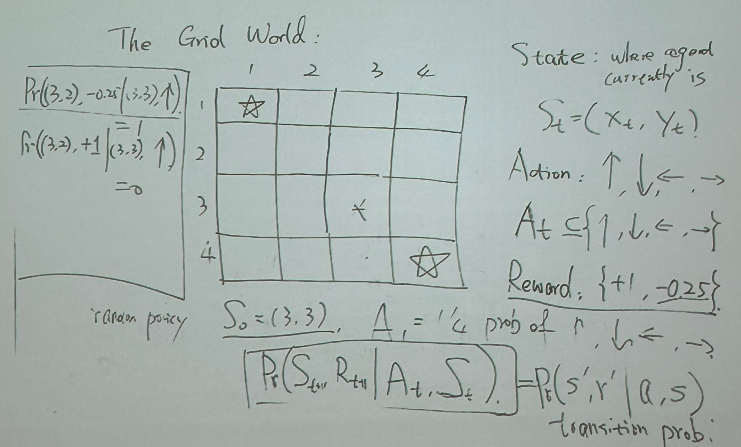

Finite, Markov are two additional conditions.  
<font color="red">Finite: means finite sets, S, A, R should be finite.</font>   
<font color="red">Markov: current state, the action that the agent is going to take at current t.</font> 

1. The probability is written in a 2D perspective  
2. Solely knowing a under state s at this point is not enough to know the next, also need to know the history before this -> this is non-markov
3. Markov only need to know the current point for the agent to know the next steo, i.e. don't care about how you get to this point (i.e. the history until current point)  

In bandit machine problem, the state is static i.e. time invariant  
But in FMDP, the state will chage i.e. time variant, the same action under different states has different quality  
For example, in the Grid World Game:  
"going down" in (2, 2) is getting away from the treasure -> small reward
"going down" in (4, 3) is getting close to the treasure -> large reward

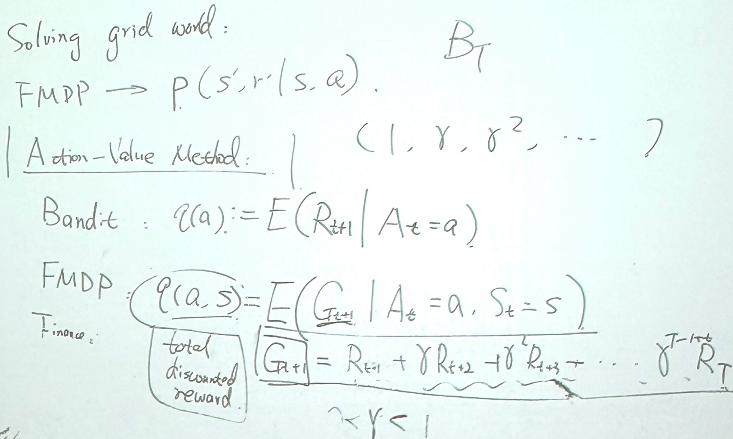

Bandit: q(a) the action has exactly one step of impact  
FMDP: q(a, s) the action has long-term impact so we are going to consider the future as well, that's why we also care about the total discounted reward  

 # What is Markov Decision Process (MDP)? <a name="intro"></a>

## Definition and Notations of MDP <a name="definition"></a>

## Things to arrage
1. If I can know 𝑝(𝑠′,𝑟|𝑠,𝑎) explicitly, it's powerful that I can derive the next without historical data
2. We have to estimate the value in the bandit problem, but here if we know the dynamic, we don't need to compute  
3. G_t+2 starts counting a step further, not immediately, so need to factor out the next step  
4. state-value function: the summary of the state, how good it is to be in a certain state, given a particular policy 

Most problems that RL is designed to solve can be thought of as **sequential decision-making** problems, i.e., an agent interacts with some environment by taking a sequence of actions in order to maximize reward. Markov Decision Process (MDP) is a classic formulation of sequential decision-making. 

Recall the agent-environment framework that we discussed last time.

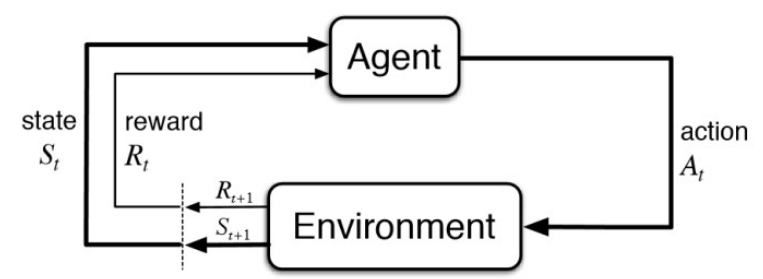

Let's now define the agent, environment, action, states, reward, value, and policy for a MDP.

A MDP involves an agent (i.e., the decision maker) that interacts with the environment sequentially over time steps $t \in \{1,2,\ldots\}$ (the total time steps could be finite or infinite, more on this later). 

At each time step $t$, the agent observes state $S_t$ of the environment (i.e., the situation faced by the agent), based on which it takes action $A_t$, which results in a reward $R_{t+1}$ and a new state of the environment $S_{t+1}$. So, a MDP can be thought of as a sequence of state, action, and reward: $S_1, A_1, R_2, S_2, A_2, R_3, \ldots$. <font color="blue">Note that, unlike the bandit model, the states of the environment are crucial for describing a MDP, because the states are affected by, and also affect, the agent's actions. A bandit model can be treated as a MDP with only 1 state that never changes</font>.

For this lecture (and much of RL), we consider **Finite** MDP, which means that the state, reward, and action all take values from _finite sets_, respectively  $\mathcal{S}$, $\mathcal{R}$, and $\mathcal{A}$.

To describe the above agent-environment interactions mathematically, we simply write down the probability of observing state $S_{t+1}$ and getting reward $R_{t+1}$ if the agent takes action $A_t$ at state $S_t$:
$$p(s', r | s, a) \doteq \Pr(S_{t+1} = s', R_{t+1} = r | S_t = s, A_t = a)$$
where $s,s' \in \mathcal{S}$, $r \in \mathcal{R}$, and $a \in \mathcal{A}$. This is called the **dynamics** of the MDP.

<font color="red">So, what's "Markov"?</font> A MDP is said to have the **Markov property** if the four-element dynamics $p(s', r | s, a)$ _fully_ describes the MDP without having to look further back into the history. That is
$$\Pr(S_{t+1} = s', R_{t+1} = r | S_t = s, A_t = a) = \Pr(S_{t+1}, R_{t+1} | S_t, A_t, S_{t-1}, A_{t-1}, \ldots)$$
In other words, **the future is independent of the past given the present**. The Markov property makes sequential decision-making problems much easier to describe and solve, although it is not always true.

Using the dynamics $p(s', r | s, a)$, we can easily calculate other quantities of interest. For example:
- **State Transition Probabilities**: given you are in $S_t$ and takes action $A_t$, the probability that you will end up in $S_{t+1}$: $p(s' | s, a) = \sum_{r \in \mathbb{R}} p(s', r | s, a)$;
- **Expected Reward for State-Action Pair**: $r(s,a) = \mathbb{E} (R_{t+1} | S_t = s, A_t = a) = \sum_{r \in \mathbb{R}} r \cdot \sum_{s' \in \mathbb{S}} p(s', r | s, a)$.

**So what's our goal in a MDP problem?** We want to choose an action to maximize total reward! Here, we introduce a more general formulation of total reward, called the **discounted total return**:
$$G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... = \sum_{k=0}^{+\infty} \gamma^k R_{t+k+1}$$
where $\gamma \in [0,1]$ is called the **discount rate**. If a MDP has finite number of steps $T$, simply replace $+\infty$ in the summation with $T$. Intuitively, $G_t$ measures the total future reward starting from time $t$. Our goal is to take action $A_t$ to maximize $G_t$.

<font color="blue">Why do we need discounting?</font>
- If the MDP goes for infinite number of steps, having a discount $\gamma < 1$ makes sure that the return is finite. This is mathematically desirable;
- Discount rate intuitively reflects how _myopic vs. forward-looking_ the agent behaves. Smaller $\gamma$ means that the agent is more myopic - it cares more about short-term return rather than long-term return. **This is important in MDP because you need to consider the long-term consequences of your action**.
- If reward is in the form of money, then it intuitively gains value over time. Discounting follows the same concept of compound interest.

<font color="red">Question: think about the bandit model from last time. Do you see any disconnect?</font> It seems that when picking $A_t$, we were just trying to maximize the immediate reward. Recall we defined $q(a) = \mathbb{E}(R_{t+1} | A_t = a)$ and pick $A_t$ to maximize $q(a)$. This is because, in a bandit model, you action at time $t$ does not have any impact on reward beyond $R_{t+1}$. Every time you finish pulling an arm, you get an immediate reward, and then the bandit machine returns to what it was before you pulled it. This again highlights the importance of **states** in dealing with a general MDP problem, where your action can have long-lasting impact, and only maximizing immediate reward can be too myopic.

Finally, let's define **policy** and **value functions** for MDP.

Policy is the mapping between states and actions, it tells you what to do when:
$$\pi(a | s) = \Pr(A_t = a | S_t = s)$$
As a special case, the policy can also be a deterministic mapping, i.e., always take certain action $a$ when in situation $s$. In that case, people sometimes write the policy function to be $\pi(s)$.

There are two types of value functions in a general MDP: a state-value function and an action-value function.

The **State-Value Function** describes how good it is to be in a certain state, given a particular policy:
$$v_{\pi}(s) = \mathbb{E}(G_t | S_t = s)$$
<font color="blue">We don't have this for bandit, because there's only 1 state. the state value is just the total reward.</font>

The **Action-Value Function** describes how good it is to take a certain action in a certain state, given a particular policy:
$$q_{\pi}(s, a) = \mathbb{E}(G_t | S_t = s, A_t = a)$$

The state-value function and the action-value function can be converted to each other:
$$v_{\pi}(s) = \sum_a \pi(a | s) q_{\pi}(s, a)$$
$$q_{\pi}(s, a) = \sum_{s',r} p(s', r | s, a) [r + \gamma v_{\pi}(s')] $$

Accordingly, we can define the **optimal state-/action-value functions** as the functions under optimal policy:
$$v^*(s) = \max_{\pi} v_{\pi}(s)$$
$$q^*(s,a) = \max_{\pi} q_{\pi}(s,a)$$

## An Example: The Grid <a name="example"></a>

Let's get comfortable with all these terminologies using an example. This example is adapted from Sutton and Barto Chapter 4 (Example 4.1).

**Environment:** Consider a 4-by-4 grid, where the top-left and bottom-right corners each has a prize whereas other 14 cells have nothing (free cells). 

**Agents, Goal, and Action:** An agent starts in a free cell, and the goal is to get to a prize in the least number of moves. If the agent hits a prize cell, then the game terminates. In any free cell, the agent has 4 possible actions: go up, go down, go left, and go right. The agent can travel 1 cell at a time.

**Reward:**
- The prize is worth 1.0 point;
- Going from a free cell to another free cell is worth -0.25 point (<font color="red">think about why we add a small negative reward here.</font>).

In [2]:
# Import packages
import numpy as np

In [3]:
# Make a 4 by 4 numpy array
grid = np.array([
    ['prize','free','free','free'],
    ['free','free','free','free'],
    ['free','free','free','free'],
    ['free','free','free','prize']
])
grid

array([['prize', 'free', 'free', 'free'],
       ['free', 'free', 'free', 'free'],
       ['free', 'free', 'free', 'free'],
       ['free', 'free', 'free', 'prize']], dtype='<U5')

In [4]:
# Define possible / allowable actions in each state
# In this example, when you are on the edge of the grid, some actions are not allowed
legal_actions = {}
for sr in range(4):
    for sc in range(4):
        if (sr,sc) != (0,0) and (sr,sc) != (3,3):  # excluding terminal states (no more movement after you hit the prize)
            legal_actions[(sr,sc)] = []
            if sr > 0:  # can always go up
                legal_actions[(sr,sc)].append('up')
            if sr < 3:  # can always go down
                legal_actions[(sr,sc)].append('down')
            if sc > 0:  # can always go left
                legal_actions[(sr,sc)].append('left')
            if sc < 3:  # can always go right
                legal_actions[(sr,sc)].append('right')

In [44]:
# Now, let's create the dynamics of this MDP: p(s', r | s, a)
# First try a few examples by hand, then write the code
# Using a dictionary to achieve this, keys are (s1r, s1c, a, s2r, s2c, r)
p = dict()

# there are two possible reward types in this case: reward of the prize and reward of traveling between free cells
r_prize = 1.0
r_walk = -0.25
#r_walk = 0.0
#r_walk = -1.0

# Initialize with all 0
for s1r in range(4):
    for s1c in range(4):
        for a in ['up', 'down', 'left', 'right']:
            for s2r in range(4):
                for s2c in range(4):
                    for r in [r_walk, r_prize]:
                        p[(s1r, s1c, a, s2r, s2c, r)] = 0.0

# Now, fill the entries, by traversing (s1r, s1c)
for s1r in range(4):
    for s1c in range(4):
        if (s1r,s1c) != (0,0) and (s1r,s1c) != (3,3):  # excluding terminal states
            # go over each of the four moves
            # right
            if 'right' in legal_actions[(s1r,s1c)]:
                s2r = s1r
                s2c = s1c + 1
                if grid[s2r,s2c] == 'prize':
                    p[(s1r, s1c, 'right', s2r, s2c, r_prize)] = 1.0
                else:
                    p[(s1r, s1c, 'right', s2r, s2c, r_walk)] = 1.0
            # left
            if 'left' in legal_actions[(s1r,s1c)]:
                s2r = s1r
                s2c = s1c - 1
                if grid[s2r,s2c] == 'prize':
                    p[(s1r, s1c, 'left', s2r, s2c, r_prize)] = 1.0
                else:
                    p[(s1r, s1c, 'left', s2r, s2c, r_walk)] = 1.0
            # up
            if 'up' in legal_actions[(s1r,s1c)]:
                s2r = s1r - 1
                s2c = s1c
                if grid[s2r,s2c] == 'prize':
                    p[(s1r, s1c, 'up', s2r, s2c, r_prize)] = 1.0
                else:
                    p[(s1r, s1c, 'up', s2r, s2c, r_walk)] = 1.0
            # down
            if 'down' in legal_actions[(s1r,s1c)]:
                s2r = s1r + 1
                s2c = s1c
                if grid[s2r,s2c] == 'prize':
                    p[(s1r, s1c, 'down', s2r, s2c, r_prize)] = 1.0
                else:
                    p[(s1r, s1c, 'down', s2r, s2c, r_walk)] = 1.0

# try a few examples
print(p[(0,1,'left',0,0,1.0)])
print(p[(1,2,'down',2,2,1.0)])
print(p[(1,2,'down',2,2,-0.25)])

1.0
0.0
1.0


# Solving MDP: Action-Value Methods <a name="solution_action_value"></a>

As we have learned from the bandit model, the action-value methods to solve RL problems seek to somehow **estimate the value functions**, then take actions accordingly. We talk about several different methods in this part, including policy iteration, value iteration, and Monte Carlo methods.

## Policy Iteration <a name="policy_iteration"></a>

The basic idea of the policy iteration approach is: starting from a random (and probably bad) policy, then iteratively improve it until it converges to the optimal policy.

To achieve policy iteration, we need to ingredients:
1. **Policy Evaluation**: We need a way to evaluate how good a policy is;
2. **Policy Improvement**: We need a way to improve a policy (i.e., make it better).

As long as we can correctly evaluate a policy and (strictly) improve it, we can _always_ converge to the optimal policy in finite number of steps - this is because in a _finite_ MDP, there are only a finite number of possible policies.

### Policy Evaluation <a name="policy_evaluation"></a>

The goal of policy evaluation is: given a policy $\pi$, compute the state-value function $v_{\pi}(s)$ for all $s\in \mathbb{S}$.

This is achieved via a tool called the **Bellman equation**. While it gets too technical to explain the math behind it, here's the _(very) high-level intuition_: the Bellman equation is a way to express the value of a problem (just like the state values that we are trying to compute here) at time $t$ as a function of the values of that problem in the remaining time steps. In other words, it writes down the **recursive** relationship between the values of the problem at different time points. Why doing this? Because, ideally, if we know how to take the best action at the final time step, we can leverage the recursive relationship to backtrack and solve for the best strategy at each step.

This is probably still very abstract. So let's look at how it works out in the case of policy evaluation. The idea here is we want to express $v_{\pi}(s)$ as a function of $v_{\pi}(s')$, where $s'$ is the state that the agent will be in the next time period after $s$ (i.e., the agent goes from $s$ to $s'$).

Here' the math, don't worry too much if you don't fully understand every detail here:
\begin{equation}
\begin{split}
    v_{\pi}(s) &= \mathbb{E}(G_t | S_t = s) \\
    &= \mathbb{E}(R_{t+1} + \gamma G_{t+1} | S_t = s) \\
    &= \mathbb{E}(R_{t+1} | S_t = s) + \gamma \mathbb{E}(G_{t+1} | S_t = s) \\
    &= \sum_a \pi(a | s) \sum_{s',r} p(s', r | s, a) \cdot r + \sum_a \pi(a | s) \sum_{s',r} p(s', r | s, a) \cdot \gamma v_{\pi}(s') \\
    &= \sum_a \pi(a | s) \sum_{s',r} p(s', r | s, a) \cdot [r + \gamma v_{\pi}(s')]
\end{split}
\end{equation}
Looking at the last line, it is simply an expectation over actions: probability of taking action $a$ under policy $\pi$ (i.e., $\pi(a | s)$) multiplied by the value of action $a$ that takes the agent from state $s$ to state $s'$.


This Bellman equation gives us a way to compute $v_{\pi}(s)$ in an iterative manner, as follows:
1. Initialize the values of $v_{\pi}(s)$ (e.g., all 0);
2. Pick a precision level $\delta$ (typically a small positive number, such as 0.01);
3. Iteratively update the values of $v_{\pi}(s)$ via: $v_{k+1}(s) = \sum_a \pi(a | s) \sum_{s',r} p(s', r | s, a) \cdot [r + \gamma v_{k}(s')]$, where $k$ is the iteration round index. Until the difference in $v_{\pi}(s)$ between two iterations is smaller than $\delta$. <font color="blue">Note: here s is an "origin" state and s' is a "destination" state. Therefore, s can not be the terminal states. However, s' can be any states (including the terminal states).</font>

In [45]:
# Let's first write down a representation of a policy
# As a baseline, perhaps start with a random policy (i.e., randomly take action)
# I'm again using a dictionary data structure here, with keys (sr, sc, a)
pi_random = dict()
for sr in range(4):
    for sc in range(4):
        if (sr, sc) != (0,0) and (sr, sc) != (3,3):  # excluding terminal states
            # randomly pick a possible direction (i.e., anywhere except outside the grid)
            for a in legal_actions[(sr,sc)]:
                pi_random[(sr, sc, a)] = 1.0/float(len(legal_actions[(sr,sc)]))

In [46]:
# Now, let's implement iterative policy evaluation (see Sutton and Barto Chapter 4.1)
# For simplicity, we assume gamma = 1. It's easy to add gamma if you want
def policyEval(pi, p, delta):
    # pi is the policy dictionary, p is the four-element p(s',r|s,a) dictionary
    # delta is the precision level
    # First, initialize the state values (all 0, for example)
    V = np.zeros((4,4))
    # Next, start the iteration
    while True:
        V_curr = np.copy(V)
        for s1r in range(4):
            for s1c in range(4):
                if (s1r, s1c) != (0,0) and (s1r, s1c) != (3,3):  # excluding terminal states
                    temp = 0.0
                    # start the update via Bellman equation
                    for a in legal_actions[(s1r, s1c)]:
                        action_prob = pi[(s1r, s1c, a)]
                        for s2r in range(4):
                            for s2c in range(4):
                                for r in [r_prize, r_walk]:
                                    temp += action_prob*p[(s1r, s1c, a, s2r, s2c, r)]*(r + V_curr[s2r, s2c])
                    V[s1r, s1c] = temp
                    max_diff = np.max(abs(V_curr - V))
        if max_diff < delta:
            break
    return V

In [47]:
# try it out on our random policy
V_random = policyEval(pi_random, p, 0.001)
print(V_random)
# What do you see? What does it mean? Does it tell you about the quality of the random policy?

[[ 0.         -1.49427214 -2.6169505  -2.86606777]
 [-1.49427214 -2.36756408 -2.74140821 -2.6169505 ]
 [-2.6169505  -2.74140821 -2.36756408 -1.49427214]
 [-2.86606777 -2.6169505  -1.49427214  0.        ]]


### Policy Improvement <a name="policy_improvement"></a>
**Not like the gradient you might get stuck in the local optimal, in policy iteration, everytime you are guaranteed to get a better policy**

Now that we know how to evaluate a given policy, how do we improve upon it?

Intuitively (and same idea as in the bandit model), we want to pick the action with the highest value. In other words, we want to pick:
$$\arg\max_a q_{\pi} (s, a)$$

Recall that $q_{\pi} (s, a) = \sum_{s',r} p(s', r | s, a) \cdot [r + \gamma v_{\pi}(s')]$ is the value of action $a$ that takes the agent from state $s$ to state $s'$. The above is thus the same as:
$$\arg\max_a \sum_{s',r} p(s', r | s, a) \cdot [r + \gamma v_{\pi}(s')]$$

- If there's only one action with the highest value, call it $a^*$, then we simply update out policy to be: $\pi'(a^*|s) = 1.0, \text{and for all } a \neq a^*, \pi'(a|s) = 0.0$;
- If there are more than one actions with (equal) highest value, then just divide the probability among them equally.

Mathematically, one can show such an updating method _always_ result in a better policy (see Sutton and Barto Chapter 4.2 for proof if interested).

In [48]:
# define a policy improvement function
def policyImprove(p, V):
    # p is the four-element p(s',r|s,a) dictionary
    # V is the state-value functions under current policy
    # First initialize an empty policy
    pi_new = dict()
    
    # Now, go through each state
    for s1r in range(4):
        for s1c in range(4):
            if (s1r, s1c) != (0,0) and (s1r, s1c) != (3,3):  # excluding terminal states
                action_values = []  # to store the values of each action, from which we find the max
                for a in legal_actions[(s1r, s1c)]:
                    temp = 0.0
                    for s2r in range(4):
                        for s2c in range(4):
                            for r in [r_prize, r_walk]:
                                    temp += p[(s1r, s1c, a, s2r, s2c, r)]*(r + V[s2r, s2c])
                    action_values.append(temp)
                # find the value-maximizing action(s)
                max_value = max(action_values)
                max_pos = [i for i, j in enumerate(action_values) if j == max_value]
                max_len = len(max_pos)
                for i in range(len(legal_actions[(s1r, s1c)])):
                    if i in max_pos:  # this is a value-maximizing action
                        pi_new[(s1r, s1c, legal_actions[(s1r, s1c)][i])] = 1.0/float(max_len)   # equally divide probability
                    else:
                        pi_new[(s1r, s1c, legal_actions[(s1r, s1c)][i])] = 0.0  # non-value-maximizing action gets probibility 0
    return pi_new

Finally, policy iteration is achieved by going back and forth between policy evaluation and policy improvement, until the policy doesn't change anymore.

In [49]:
# Complete policy iteration
# Start with the random policy
pi = dict.copy(pi_random)
while True:
    pi_curr = dict.copy(pi)
    # policy evaluation
    V_pi = policyEval(pi, p, 0.001)
    # policy improvement
    pi = policyImprove(p, V_pi)
    #print(pi)
    if pi == pi_curr:
        break

print(pi)

{(0, 1, 'down'): 0.0, (0, 1, 'left'): 1.0, (0, 1, 'right'): 0.0, (0, 2, 'down'): 0.0, (0, 2, 'left'): 1.0, (0, 2, 'right'): 0.0, (0, 3, 'down'): 0.5, (0, 3, 'left'): 0.5, (1, 0, 'up'): 1.0, (1, 0, 'down'): 0.0, (1, 0, 'right'): 0.0, (1, 1, 'up'): 0.5, (1, 1, 'down'): 0.0, (1, 1, 'left'): 0.5, (1, 1, 'right'): 0.0, (1, 2, 'up'): 0.25, (1, 2, 'down'): 0.25, (1, 2, 'left'): 0.25, (1, 2, 'right'): 0.25, (1, 3, 'up'): 0.0, (1, 3, 'down'): 1.0, (1, 3, 'left'): 0.0, (2, 0, 'up'): 1.0, (2, 0, 'down'): 0.0, (2, 0, 'right'): 0.0, (2, 1, 'up'): 0.25, (2, 1, 'down'): 0.25, (2, 1, 'left'): 0.25, (2, 1, 'right'): 0.25, (2, 2, 'up'): 0.0, (2, 2, 'down'): 0.5, (2, 2, 'left'): 0.0, (2, 2, 'right'): 0.5, (2, 3, 'up'): 0.0, (2, 3, 'down'): 1.0, (2, 3, 'left'): 0.0, (3, 0, 'up'): 0.5, (3, 0, 'right'): 0.5, (3, 1, 'up'): 0.0, (3, 1, 'left'): 0.0, (3, 1, 'right'): 1.0, (3, 2, 'up'): 0.0, (3, 2, 'left'): 0.0, (3, 2, 'right'): 1.0}


It is indeed the optimal policy! If you visualize the above policy, it looks like the following:

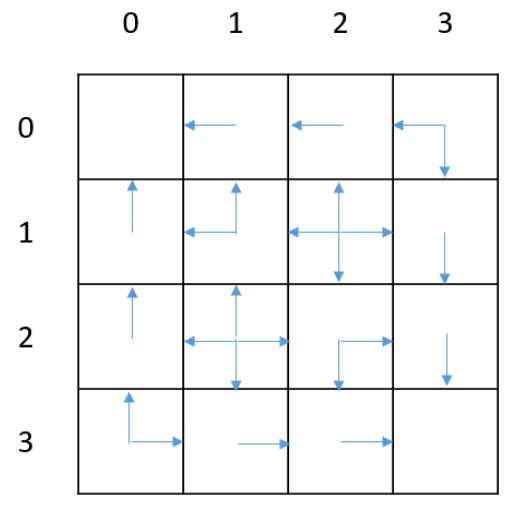

## Value Iteration <a name="value_iteration"></a>

One limitation of policy iteration is that every round of policy evaluation and policy improvement involves looping through _all_ states of the MDP to perform updates (just recall how many for loops we have written for the above simulation). This can be wasteful sometimes. It turns out that one can **combine** policy evaluation and improvement in a single iteration, using the so called **value iteration** approach.

To understand how value iteration works, let's first consider the Bellman equation of optimal value-state functions $v^*(s)$. In other words, imagine we have already found $v^*(s)$, what recursive property (described by Bellman equation) would it have? 
\begin{equation}
\begin{split}
    v^*(s) &= \max_a \mathbb{E}(R_{t+1} + \gamma v^*(S_{t+1}) | S_t = s, A_t = a) \\
    &= \max_a \sum_{s',r} p(s', r | s, a) \cdot [r + \gamma v^*(s')]
\end{split}
\end{equation}
<font color="blue">Although the above derivation is not required, it is actually not too difficult. Same as before, imagine taking the optimal action (hence $\max_a$) that moves the agent from state $s$ to state $s'$.</font>

This Bellman equation gives the following update rule:
$$v_{k+1}(s) = \max_a \sum_{s',r} p(s', r | s, a) \cdot [r + \gamma v_k(s')]$$

So, value iteration follows this update rule until the changes in value-state functions are small enough. Let's implement it to see.

In [11]:
# Now, let's implement value iteration (see Sutton and Barto Chapter 4.4)
# For simplicity, we again assume gamma = 1.
def valueIteration(p, delta):
    # p is the four-element p(s',r|s,a) dictionary
    # delta is the precision level
    # First, initialize the state values (all 0, for example)
    V = np.zeros((4,4))
    # Next, start the iteration
    while True:
        V_curr = np.copy(V)
        for s1r in range(4):
            for s1c in range(4):
                if (s1r, s1c) != (0,0) and (s1r, s1c) != (3,3):  # excluding terminal states
                    max_action = 0.0
                    # start the update via Bellman equation
                    for a in legal_actions[(s1r, s1c)]:
                        temp = 0.0
                        for s2r in range(4):
                            for s2c in range(4):
                                for r in [r_prize, r_walk]:
                                    temp += p[(s1r, s1c, a, s2r, s2c, r)]*(r + V_curr[s2r, s2c])
                        max_action = max(max_action, temp)
                    V[s1r, s1c] = max_action
                    max_diff = np.max(abs(V_curr - V))
        if max_diff < delta:
            break
    
    # After the value iteration is finished, retrieve the optimal policy
    # First initialize an empty policy
    pi = dict()
    
    # Now, go through each state
    for s1r in range(4):
        for s1c in range(4):
            if (s1r, s1c) != (0,0) and (s1r, s1c) != (3,3):  # excluding terminal states
                action_values = []  # to store the values of each action, from which we find the max
                for a in legal_actions[(s1r, s1c)]:
                    temp = 0.0
                    for s2r in range(4):
                        for s2c in range(4):
                            for r in [r_prize, r_walk]:
                                    temp += p[(s1r, s1c, a, s2r, s2c, r)]*(r + V[s2r, s2c])
                    action_values.append(temp)
                # find the value-maximizing action(s)
                max_value = max(action_values)
                max_pos = [i for i, j in enumerate(action_values) if j == max_value]
                max_len = len(max_pos)
                for i in range(len(legal_actions[(s1r, s1c)])):
                    if i in max_pos:  # this is a value-maximizing action
                        pi[(s1r, s1c, legal_actions[(s1r, s1c)][i])] = 1.0/float(max_len)   # equally divide probability
                    else:
                        pi[(s1r, s1c, legal_actions[(s1r, s1c)][i])] = 0.0  # non-value-maximizing action gets probibility 0
    return pi

In [12]:
# Complete value iteration
pi = valueIteration(p, 0.001)
print(pi)

{(0, 1, 'down'): 0.0, (0, 1, 'left'): 1.0, (0, 1, 'right'): 0.0, (0, 2, 'down'): 0.0, (0, 2, 'left'): 1.0, (0, 2, 'right'): 0.0, (0, 3, 'down'): 0.5, (0, 3, 'left'): 0.5, (1, 0, 'up'): 1.0, (1, 0, 'down'): 0.0, (1, 0, 'right'): 0.0, (1, 1, 'up'): 0.5, (1, 1, 'down'): 0.0, (1, 1, 'left'): 0.5, (1, 1, 'right'): 0.0, (1, 2, 'up'): 0.25, (1, 2, 'down'): 0.25, (1, 2, 'left'): 0.25, (1, 2, 'right'): 0.25, (1, 3, 'up'): 0.0, (1, 3, 'down'): 1.0, (1, 3, 'left'): 0.0, (2, 0, 'up'): 1.0, (2, 0, 'down'): 0.0, (2, 0, 'right'): 0.0, (2, 1, 'up'): 0.25, (2, 1, 'down'): 0.25, (2, 1, 'left'): 0.25, (2, 1, 'right'): 0.25, (2, 2, 'up'): 0.0, (2, 2, 'down'): 0.5, (2, 2, 'left'): 0.0, (2, 2, 'right'): 0.5, (2, 3, 'up'): 0.0, (2, 3, 'down'): 1.0, (2, 3, 'left'): 0.0, (3, 0, 'up'): 0.5, (3, 0, 'right'): 0.5, (3, 1, 'up'): 0.0, (3, 1, 'left'): 0.0, (3, 1, 'right'): 1.0, (3, 2, 'up'): 0.0, (3, 2, 'left'): 0.0, (3, 2, 'right'): 1.0}


We got exactly the same optimal policy as the one from policy iteration!

<font color="blue">Comment: </font> even though it might seem that value iteration is more efficient (i.e., strictly faster) than policy iteration, and one should always use value iteration, _this is actually not the case_. For example, policy iteration might be faster than value iteration if the policy converges to the optimal policy _before_ the value-state functions are fully converged to their optimal values.  

In practice, both are widely used and neither is strictly better than the other. In the limit, both converge to find the optimal policy.

## Monte Carlo Methods <a name="monte_carlo"></a>

Explore randomness, estimate, improve the policy 
Adopt some policy, record you historical state, estimate q(a, s)  
like learn to play a game by mess around, you will learn from the mistake  


### Reflections on Policy Iteration and Value Iteration <a name="reflection"></a>

Both policy iteration and value iteration are examples of **Dynamic Programming (DP)**. They are useful, but they rely on a critical assumption / prerequisite: that **we have complete information about the environment**, i.e., we know $p(s', r | s, a)$ for all $s,s' \in \mathcal{S}$, all $r \in \mathcal{R}$, and all $a \in \mathcal{A}$. Every step of the way, we need these four-element probabilities to evaluate and improve policy. 

Having complete knowledge of the environment has provided us with many benefits:
1. Unlike in the bandit case, where value functions have to be _estimated_, here they can directly be _computed_;
2. Remember exploration vs. exploitation? We hardly need to worry about that in policy iteration or value iteration;
3. We don't necessarily need to compute $q_{\pi}(s,a)$ (which is typically needed to get the optimal policy). Instead, we can compute $v_{\pi}(s)$ (which is computationally cheaper) and rely on $p(s', r | s, a)$ to get the optimal policy. 

This assumption may be realistic for some tasks, e.g., game-play where the rules of the game is known and easy to represent (just like in the grid example). However, as you can imagine, for many other tasks where (1) the rules are unknown or (2) the rules are very hard to represent / codify, we need to other methods. Monte Carlo is one such methods.

### Basic Ideas of Monte Carlo Methods <a name="monte_carlo_idea"></a>

The basic ideas of Monte Carlo Methods are the same as what we have used to solve the bandit model: **<font color="blue">Learn from actual interactions with the environment.</font>**

The procedure of Monte Carlo method is quite similar to that of policy iteration:
1. For a given policy $\pi$, we try to estimate $q_{\pi}(s,a)$ for all $s \in \mathcal{S}$ and all $a \in \mathcal{A}$. This is basically policy evaluation - we want to know how good the policy is;
2. Next, we improve the current policy by taking actions according to $\arg\max_a q_{\pi}(s,a)$ for state $s$. This is policy improvement;
3. Repeat 1-2 for a sufficiently large number of rounds. <font color="red">Question: why don't we iterate till the policy stops changing?</font> This is not immediately clear - will answer it after implementation.

But how do we estimate $q_{\pi}(s,a)$? Recall its definition:
$$q_{\pi}(s,a) = \mathbb{E}(G_t | S_t = s, A_t = a)$$
So, here is the outline:
1. Generate many sequences of actions and the resulting states and rewards (i.e., interact with the environment many times). Each sequence has a starting state, then follows the given policy until it reaches a terminal state. In our grid example, the process of generating a sequence is like wandering around in the grid until hitting one of the terminal states;
2. In a given sequence, average the returns associated with a particular state-action pair (i.e., use sample average to approximate expectation). This is the same as what we did for bandit models.

### Monte Carlo with Exploring Starts (Monte Carlo ES) <a name="MCES"></a>

Before we start implementing the Monte Carlo method. There is one small but important obstacle. In order to estimate all $q_{\pi}(s,a)$, we need to "visit" all pairs of $s,a$ at least once (preferably several times). How do we guarantee that? In other words, <font color="blue">how do we ensure sufficient exploration before we start to exploit?</font>

Recall we face a similar problem in the bandit model: in order to know how good each arm is, we need to explore/try each arm at least a few times. So many of the similar ideas (e.g., optimistic initial values, $\varepsilon$-greedy approach, etc.) are also applicable here. 

For starter, let's try an approach called "Exploring Starts". Specifically, when generating the sequences, we make sure that every pair of state-action pair has some non-zero probability of being the initial state.

Now, let's implement Monte Carlo with exploring starts for our grid example.

In [13]:
# Preparation: let's define a convenient function for moving around in the 4-by-4 grid
def move(sr1, sc1, a):
    # If I'm in (sr1,sc1) and take action a, where would I be next?
    # assuming a is a legal action
    if a == 'right':
        sr2 = sr1
        sc2 = sc1 + 1
    if a == 'left':
        sr2 = sr1
        sc2 = sc1 - 1
    if a == 'up':
        sr2 = sr1 - 1
        sc2 = sc1
    if a == 'down':
        sr2 = sr1 + 1
        sc2 = sc1
    return (sr2, sc2)

In [14]:
# Preparation: let's write a function that generates a sequence based on a policy
# One complication for this grid problem is that, depending on pi and initial state, you may be stuck in an infite loop (Can anyone give an example?)
# To avoid that, we will return a special value if the sequence is too long
def genSeq(pi, sr_start, sc_start):
    # (sr_start, sc_start) is the starting state (i.e., where the agent is at the beginning)
    sr, sc = sr_start, sc_start
    # keep lists for states, actions, and rewards
    state_seq, action_seq, reward_seq = [(sr,sc)], [], []
    # now, keep wandering until hitting the terminal states
    while True:
        # pick an action based on current policy
        action_prob = []
        for a in legal_actions[(sr,sc)]:
            action_prob.append(pi[(sr,sc,a)])        
        a = np.random.choice(legal_actions[(sr,sc)], p = action_prob)
        action_seq.append(a)
        # move
        sr, sc = move(sr, sc, a)
        if (sr,sc) == (0,0) or (sr,sc) == (3,3): # terminal states reached
            reward_seq.append(r_prize)
            flag = 'ended normally'
            break
        elif len(state_seq) > 200:  # we appear to be in an infinite loop
            flag = 'infinite loop'
            break
        else:  # append reward and subsequent state
            reward_seq.append(r_walk)
            state_seq.append((sr,sc))
    return [state_seq, action_seq, reward_seq, flag]

In [15]:
# try it out
states, actions, rewards, flag = genSeq(pi_random, 1, 1)
print(states)
print(actions)
print(rewards)
print(flag)

[(1, 1), (0, 1), (0, 2), (1, 2), (2, 2), (3, 2), (3, 1), (2, 1), (1, 1), (1, 0), (1, 1), (1, 2), (2, 2), (2, 1), (2, 2), (2, 1), (3, 1), (3, 0), (2, 0), (2, 1), (3, 1), (3, 0), (2, 0), (2, 1), (2, 2), (2, 1), (1, 1), (0, 1), (0, 2), (1, 2), (1, 1), (2, 1), (2, 2), (2, 3), (1, 3), (1, 2), (2, 2), (2, 1), (2, 0), (2, 1), (2, 2), (2, 3), (1, 3), (2, 3), (1, 3), (1, 2), (2, 2), (1, 2), (2, 2), (3, 2), (2, 2), (1, 2), (2, 2), (3, 2)]
['up', 'right', 'down', 'down', 'down', 'left', 'up', 'up', 'left', 'right', 'right', 'down', 'left', 'right', 'left', 'down', 'left', 'up', 'right', 'down', 'left', 'up', 'right', 'right', 'left', 'up', 'up', 'right', 'down', 'left', 'down', 'right', 'right', 'up', 'left', 'down', 'left', 'left', 'right', 'right', 'right', 'up', 'down', 'up', 'left', 'down', 'up', 'down', 'down', 'up', 'up', 'down', 'down', 'right']
[-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25

In [16]:
# Now, putting MCES together
def MCES():
    # Start with a random policy
    pi = dict.copy(pi_random) 
    # Initialize three dictionaries to store (1) action-values and (2) number of times (s,a) have been visited
    Q, visits = {}, {}
    # Initialize a list of all non-terminal states (all that could be the initial state)
    non_terminal_states = []
    for sr in range(4):
        for sc in range(4):
            if (sr,sc) != (0,0) and (sr,sc) != (3,3):
                non_terminal_states.append((sr,sc))
                for a in legal_actions[(sr,sc)]:
                    Q[(sr,sc,a)] = 0.0
                    visits[(sr,sc,a)] = 0
    
    # start sequence generation, policy evaluation, and policy improvement
    counter = 0
    while counter < 100:  # Learn from 100 sequences
        # randomly start in a non-terminal state
        sr_start, sc_start = non_terminal_states[np.random.randint(len(non_terminal_states))]
        state_seq, action_seq, reward_seq, flag = genSeq(pi, sr_start, sc_start)
        # if we get caught in an infinite loop, simply pick a different initial state and try again
        if flag == 'infinite loop':
            continue
        # keep track of return
        G = 0.0
        
        # now loop through the sequence (backwards) to calculate Q - this is policy evaluation
        for t in range(len(state_seq))[::-1]:
            sr, sc = state_seq[t]
            a, r = action_seq[t], reward_seq[t]
            G += r  # note: I again assumed gamma = 1. Otherwise it should be G = gamma*G + r
            Q[(sr,sc,a)] = (Q[(sr,sc,a)]*visits[(sr,sc,a)] + G) / float(visits[(sr,sc,a)]+1)
            visits[(sr,sc,a)] += 1
        
        # next do policy improvement
        for sr in range(4):
            for sc in range(4):
                if (sr, sc) != (0,0) and (sr, sc) != (3,3):  # excluding terminal states
                    action_values = []
                    for a in legal_actions[(sr,sc)]:
                        action_values.append(Q[(sr,sc,a)])
                    max_value = max(action_values)
                    max_pos = [i for i, j in enumerate(action_values) if j == max_value]
                    max_len = len(max_pos)
                    for i in range(len(legal_actions[(sr,sc)])):
                        if i in max_pos:  # this is a value-maximizing action
                            pi[(sr, sc, legal_actions[(sr,sc)][i])] = 1.0/float(max_len)   # equally divide probability
                        else:
                            pi[(sr, sc, legal_actions[(sr,sc)][i])] = 0.0  # non-value-maximizing action gets probibility 0
        counter += 1
        
    return pi

In [17]:
pi = MCES()
print(pi)

{(0, 1, 'down'): 0.0, (0, 1, 'left'): 1.0, (0, 1, 'right'): 0.0, (0, 2, 'down'): 1.0, (0, 2, 'left'): 0.0, (0, 2, 'right'): 0.0, (0, 3, 'down'): 0.5, (0, 3, 'left'): 0.5, (1, 0, 'up'): 1.0, (1, 0, 'down'): 0.0, (1, 0, 'right'): 0.0, (1, 1, 'up'): 0.0, (1, 1, 'down'): 1.0, (1, 1, 'left'): 0.0, (1, 1, 'right'): 0.0, (1, 2, 'up'): 0.0, (1, 2, 'down'): 1.0, (1, 2, 'left'): 0.0, (1, 2, 'right'): 0.0, (1, 3, 'up'): 0.0, (1, 3, 'down'): 1.0, (1, 3, 'left'): 0.0, (2, 0, 'up'): 0.0, (2, 0, 'down'): 0.0, (2, 0, 'right'): 1.0, (2, 1, 'up'): 0.0, (2, 1, 'down'): 0.0, (2, 1, 'left'): 0.0, (2, 1, 'right'): 1.0, (2, 2, 'up'): 0.0, (2, 2, 'down'): 1.0, (2, 2, 'left'): 0.0, (2, 2, 'right'): 0.0, (2, 3, 'up'): 0.0, (2, 3, 'down'): 0.0, (2, 3, 'left'): 1.0, (3, 0, 'up'): 0.0, (3, 0, 'right'): 1.0, (3, 1, 'up'): 0.0, (3, 1, 'left'): 0.0, (3, 1, 'right'): 1.0, (3, 2, 'up'): 0.0, (3, 2, 'left'): 0.0, (3, 2, 'right'): 1.0}


<font color="blue">Two comments:</font>
1. Check the optimal policy discovered by Monte Carlo ES. Do you see any difference with the optimal policy we got from policy iteration or value iteration? Take state (1,2) as an example, all four directions are optimal actions in this particular state. To discover it, you would need the action values to be _exactly_ the same. This may not be guaranteed in MCES, because every update is based on _a single randomly generated_ sequence. In general, it can be hard for MCES to discover the exact (stochastic) optimal policy like the other approaches. 
2. Answering one question from earlier - why don't we run MCES till the policy stops changing? This is again because of the randomness in sequence generation. Perhaps two consecutive sequences just _happen to_ result in no update of the policy - that doesn't necessarily mean that the policy is already optimal. 

### epsilon-Greedy Monte Carlo <a name="MC_on_policy"></a>

The Exploring Start strategy is reasonable, but may be insufficient on its own (especially for more complex problems). It only forces the agent to explore in the initial state, and the agent does no exploration afterwards. Can we build exploration into the policy searching process?

Just like in the bandit model, a straightforward approach to force the agent to _always explore a little bit_ is by adopting an $\varepsilon$-greedy approach, i.e., leave a small but non-zero ($\varepsilon$) chance of taking a non-optimal action in each step of policy improvement.

Specifically, suppose that for a state $s$, Monte Carlo estimation of $q_{\pi}(s,a)$ suggests that action $A^*$ is the best so far, i.e., $A^* = \arg\max_a q_{\pi}(s,a)$. Further denote the total number of possible actions that can be taken in state $s$ as $|\mathcal{A}_s|$. Then we update the policy as follows:
$$\pi(a|s) = \begin{cases} 1 - \varepsilon + \frac{\varepsilon}{|\mathcal{A}_s|} &\text{if } a = A^* \\
\frac{\varepsilon}{|\mathcal{A}_s|} & \text{if } a \neq A^* \end{cases}$$
In other words, given $A^*$ is the best action at state $s$ based on current experience, we exploit this action with a large probability, and explore other actions with a small probability.

In [18]:
# Let's implement epsilon-greedy MC
def MC_epsGreedy(eps):
    # Start with a random policy
    pi = dict.copy(pi_random) 
    # Initialize three dictionaries to store (1) action-values and (2) number of times (s,a) have been visited
    Q, visits = {}, {}
    # Initialize a list of all non-terminal states (all that could be the initial state)
    non_terminal_states = []
    for sr in range(4):
        for sc in range(4):
            if (sr,sc) != (0,0) and (sr,sc) != (3,3):
                non_terminal_states.append((sr,sc))
                for a in legal_actions[(sr,sc)]:
                    Q[(sr,sc,a)] = 0.0
                    visits[(sr,sc,a)] = 0
    
    # start sequence generation, policy evaluation, and policy improvement
    counter = 0
    while counter < 100:  # Learn from 100 sequences
        # randomly start in a non-terminal state
        sr_start, sc_start = non_terminal_states[np.random.randint(len(non_terminal_states))]
        state_seq, action_seq, reward_seq, flag = genSeq(pi, sr_start, sc_start)
        # if we get caught in an infinite loop, simply pick a different initial state and try again
        if flag == 'infinite loop':
            continue
        # keep track of return
        G = 0.0
        
        # now loop through the sequence (backwards) to calculate Q - this is policy evaluation
        for t in range(len(state_seq))[::-1]:
            sr, sc = state_seq[t]
            a, r = action_seq[t], reward_seq[t]
            G += r  # note: I again assumed gamma = 1. Otherwise it should be G = gamma*G + r
            Q[(sr,sc,a)] = (Q[(sr,sc,a)]*visits[(sr,sc,a)] + G) / float(visits[(sr,sc,a)]+1)
            visits[(sr,sc,a)] += 1
        
        # next do policy improvement
        for sr in range(4):
            for sc in range(4):
                if (sr, sc) != (0,0) and (sr, sc) != (3,3):  # excluding terminal states
                    action_values = []
                    for a in legal_actions[(sr,sc)]:
                        action_values.append(Q[(sr,sc,a)])
                    max_value = max(action_values)
                    max_pos = [i for i, j in enumerate(action_values) if j == max_value]
                    max_len = len(max_pos)
                    num_legal_actions = len(legal_actions[(sr,sc)])
                    for i in range(num_legal_actions):
                        if i in max_pos:  # this is a value-maximizing action
                            pi[(sr, sc, legal_actions[(sr,sc)][i])] = (1.0 - eps)/float(max_len) + eps/float(num_legal_actions)   # exploitation (can you derive the formula here by yourself?)
                        else:
                            pi[(sr, sc, legal_actions[(sr,sc)][i])] = eps / float(num_legal_actions) # exploration
        counter += 1
        
    return pi

In [19]:
pi = MC_epsGreedy(0.2)
print(pi)

{(0, 1, 'down'): 0.06666666666666667, (0, 1, 'left'): 0.8666666666666667, (0, 1, 'right'): 0.06666666666666667, (0, 2, 'down'): 0.06666666666666667, (0, 2, 'left'): 0.8666666666666667, (0, 2, 'right'): 0.06666666666666667, (0, 3, 'down'): 0.1, (0, 3, 'left'): 0.9, (1, 0, 'up'): 0.8666666666666667, (1, 0, 'down'): 0.06666666666666667, (1, 0, 'right'): 0.06666666666666667, (1, 1, 'up'): 0.8500000000000001, (1, 1, 'down'): 0.05, (1, 1, 'left'): 0.05, (1, 1, 'right'): 0.05, (1, 2, 'up'): 0.05, (1, 2, 'down'): 0.05, (1, 2, 'left'): 0.8500000000000001, (1, 2, 'right'): 0.05, (1, 3, 'up'): 0.06666666666666667, (1, 3, 'down'): 0.8666666666666667, (1, 3, 'left'): 0.06666666666666667, (2, 0, 'up'): 0.06666666666666667, (2, 0, 'down'): 0.8666666666666667, (2, 0, 'right'): 0.06666666666666667, (2, 1, 'up'): 0.05, (2, 1, 'down'): 0.05, (2, 1, 'left'): 0.05, (2, 1, 'right'): 0.8500000000000001, (2, 2, 'up'): 0.05, (2, 2, 'down'): 0.05, (2, 2, 'left'): 0.05, (2, 2, 'right'): 0.8500000000000001, (2, 3

As expected, the discovered optimal policy still has exploration probabilities "built in". But if you look at the mass of the probability in each state, you will see that it's still reflecting the same underlying optimal policy as before.

### Extension: Off-Policy Monte Carlo <a name="MC_off_policy"></a>

In Monte Carlo methods, because we no longer assume that we have complete knowledge of the environment, we have to learn from actual interactions with the environment. As a result, the balance between exploration and exploitation becomes much more important. 

The two approaches we have implemented here, namely MCES and $\varepsilon$-Greedy MC, are both examples of **On-Policy Monte Carlo**. The term "on-policy" simply refers to the strategy of taking the current policy, follow it to generate sample sequences, evaluate the policy, and then try to improve it over many iterations. In a sense, we are staying _on_ the policy when evaluating it.

There is another type of approach, called **Off-Policy Monte Carlo**. In a typical off-policy MC algorithm, there will be two policies, respectively a _behavior policy_ and a _target policy_. The target policy is the one that we evaluate and try to improve upon, whereas the behavior policy is used to generate sample sequences (based on which we do the evaluation of target policy). By designing the behavior policy carefully, one can achieve more sophisticated / advantageous balance between exploration vs. exploitation.

For those interested, please read Sutton and Barto Chapter 5.5.

# Solving MDP: Gradient Methods <a name="solution_gradient"></a>

So far, all the approaches we have talked about (policy / value iteration, Monte Carlo methods) are examples of action-value methods - all of them try to estimate the value of actions or states, and then derive the optimal policy accordingly. Just like in the bandit case, there is the alternative of gradient-based methods, which instead **estimate the probability that each action should be taken, and then revises these probability estimates via a gradient-descent-style procedure**. For Finite MDPs, this is called the **policy gradient approach**.

The mathematics involved in policy gradient approach are more difficult and elaborate than the action-value approaches. Therefore, we are not going to dive deep into all its details and implementations. Instead, I will cover the basic idea and intuition.

## Policy Gradient <a name="policy_gradient"></a>

The basic ideas behind policy gradient are almost the same as the gradient methods for bandit model. Our goal is to estimate the probability of taking an action in a given state, and we do so via a softmax parameterization:
$$\pi(a | s, \theta) \doteq \Pr(A_t = a | S_t = s, \theta) = \frac{e^{H_t(a,s,\theta)}}{\sum_b e^{H_t(b,s,\theta)}}$$
where $H(.)$ is the **preference function** and $\theta$ is a set of parameters (explained later).

<font color="blue">Note: this is a strictly more general formulation than what we had in the bandit case.</font> In particular, the preference function is defined over action-state pairs as well as some parameters, and it can be specified as you wish. For example:
- You could specify it as a linear function of state and action: $H_t(a,s,\theta) = \theta^{T} x(s,a)$, where $\theta$ are the coefficients and $x(.)$ is a function that encodes any state-action pair to a particular representation (we didn't really talk about this, you can read Chapter 9 of Sutton and Barto for more representation-related information, but for simplicity, you can just think of it as having one dummy indicator for each unique state-action pair);
- You could also specify it as the output of a neural network: $H_t(a,s,\theta) = DNN(a,s,\theta)$, where $\theta$ are the weights in the network. This is actually (a part of) the architecture used in AlphaGo.

Now that we have a specification for $\pi(a | s, \theta)$, the rest is a standard gradient ascent algorithm (<font color="red">Quiz: why is it gradient ascent rather than gradient descent?</font>), which follows two steps:
- **Step 1:** under the current policy $\pi$, generate a sample sequence of actions using the same Monte Carlo approach that we have tried before;
- **Step 2:** update parameter $\theta$ based on gradient ascent (exact formula omitted here, see the REINFORCE algorithm in Chapter 13.3 of Sutton and Barto);
- Repeat until convergence.

# Reward Design <a name="reward_design"></a>

Let's revisit a basic but extremely important topic - **the choice / design of rewards**. In the Grid example, getting the prize has a reward of 1.0 and traveling between free cells has a reward of -0.25. Why did we have these rewards? Specifically, why did traveling between free cells have a penalty of 0.25? Can we make it bigger or smaller?

To see this, try go back to the beginning and change `r_walk` to 0.0 and -1.0, respectively.
- Changing it to 0.0 means that going between free cells are costless. As a result, _any_ policy that eventually goes to the terminal cells would be optimal;
- Changing it to -1.0, in this case, does not have any undesirable effect. Our algorithms can still discover the optimal policy.

Overall, however, the design and choice of rewards in a RL problem can have profound impact on whether and how fast your algorithm can learn the optimal policy. You can think about rewards as a way to signal your preferences over the actions - good actions should be encouraged with sufficiently large rewards and undesirable actions should come with proper penalties.

While the reward design for the Grid example is quite straightforward, it is not always that simple in practice. Here are some examples / thought experiments to explain some of the intricacies.

1. (Go) Suppose you are designing AlphaGo. Go is a game with two players engaging in (potentially) many rounds of interactions, and one emerges as the winner in the end (according to some winner determination rules). How do you design the rewards?
    - Thought 1: Design reward based on end result - winner gets a positive reward, loser gets nothing (or even a penalty). What are pros and cons for this approach?
    - Thought 2: Maybe consider rewarding some intermediate good moves. What are pros and cons for this?
2. (Multi-player game) Suppose you are designing [AlphaStar](https://deepmind.com/blog/article/alphastar-mastering-real-time-strategy-game-starcraft-ii), an RL agent to play StarCraft. The game involves many different types of units (workers, buildings, soldiers, ...), each with different capabilities. Your goal is to defeat your opponent, but there are a ton of ways to do that. How do you design the rewards?
    - Can we just use the game outcome (winning / losing) as reward? Why or why not?
    - How about designing more detailed rewards to help learning? What kinds of difficulties you can think of?

# (Optional) Temporal-Difference (TD) Learning <a name="TD"></a>

## What if you don't have full information for the Dynamic? 
(the LHS of the image)  

### Learn by doing - Monte Carlo approach, usually more common case in RL
This is a relatively inefficient learning way since you have to repeat the same actions many times to learn from it   
i.e. collect data from really engaging in the game  

1. Take initial policy and do policy evaluation -> be able to gather data  
2. Try to estimate q(a, s)  
    - policy improvement, playing the game following the previous policy and learning from your mistakes  
3. There needs to be enough degree of exploration  
    - epislon
    - UCB
    - and other similar concepts and ideas
4. Actions might be correlated with each other through states  
    - {A_t}|S_t, the set of actions could change when states change  

## TD 
Consider the task of estimating the value of a particular state $S_t = s$, namely $v(s)$. The dynamic programming (DP) approaches and the Monte Carlo approaches try to estimate $v(s)$ in different ways.

The DP approaches directly try to compute $v(s)$ based on the relationship $v(s) = \mathbb{E} (G_t | S_t = s) = \mathbb{E} (R_{t+1} + \gamma G_{t+1} | S_t = s)$ and the model of the world (i.e., the complete $p(s',r|s,a)$ tuples). In contrast, Monte Carlo approaches try to estimate $v(s)$ based on observed $G_t$ (from actual experiences according to some policy).

Both DP and Monte Carlo have some drawbacks: DP makes the strong assumption that $p(s',r|s,a)$ tuples are known, and Monte Carlo can only update an estimate of $v(s)$ after an entire episode is completed (i.e., some terminal states are reached) and the final returns are observed. The Temporal-Difference (TD) learning approach seeks to overcome these two drawbacks. Like Monte Carlo, TD learns from actual experiences without assuming a model of the world. Like DP, TD does not need to wait till the end of an episode to update its estimates - it perform updates *during* an episode.

The simplest form one-step TD, aka $TD(0)$, performs an update to estimates of value functions immediately after each observed reward:
$$V(S_t) \leftarrow V(S_t) + \alpha \big[ R_{t+1} + \gamma V(S_{t+1}) - V(S_t) \big]$$
where $V(.)$ denote the estimates of value functions, $\alpha$ is a step size / learning rate and $R_{t+1} + \gamma V(S_{t+1}) - V(S_t)$ is called the TD error. 

<font color="blue">Side note: </font> you can actually write Monte Carlo estimates in the same form $V(S_t) \leftarrow V(S_t) + \alpha (G_t - V(S_t))$ and this is equivalent to the averaging estimate that we discussed before (by setting $\alpha = \frac{1}{k+1}$ where $k$ is the number of times $S_t$ is already visited before this focal update.

Based on the same logic, we can now derive TD algorithms to find optimal policy for finite MDP problems. Below, we introduce one classic on-policy algorithm and one classic off-policy algorithm.

## On-Policy TD: Sarsa <a name="sarsa"></a>

Just like in the case of Monte Carlo, the goal is is to estimate action value functions $q_{\pi}(s,a)$ for the current policy $\pi$, so that a better policy can be found via standard policy iteration (i.e., finding the action that improves the action value function at each state). This is done by the following update:
$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \big[R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t) \big]$$
where $Q()$ denote the current estimates. This is on-policy learning because the updates follow a particular policy to estimate the action value functions under that policy. To make sure that all action-state pairs are visited, we can again use exploration approaches such as $\varepsilon$-greedy.

This approach is called "Sarsa" because it uses information in the tuple $(S_t, A_t, R_{t+1}, S_{t+1}, A_{t+1})$.

## Off-Policy TD: Q-Learning <a name="qlearning"></a>

On the other hand, Q-learning tries to directly approximate the optimal $q^*(s,a)$ via the following update:
$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \big[R_{t+1} + \gamma \max_a Q(S_{t+1}, a) - Q(S_t, A_t) \big]$$
This is off-policy learning because a particular policy is only used to generate the learning episodes (i.e., our objective is not to estimate action value function under that policy per se, but to use the observed rewards to directly approximate the optimal action values).

<font color="blue">General comment: </font> TD learning is one of the most important ideas in reinforcement learning that enables "fast" learning from actual experiences. It has good theoretical guarantees - it can converge to optimal policy given reasonable choices of step size. In practice, it often converges faster than Monte Carlo approaches.

# Additional Resources <a name="resource"></a>

- [Learn more about the Bellman equation here](https://en.wikipedia.org/wiki/Bellman_equation);
- [AlphaGo Paper](https://storage.googleapis.com/deepmind-media/alphago/AlphaGoNaturePaper.pdf)

The AlphGo structure contains two main components:  

## Policy network, 𝜋(a|s)  
1. Train 𝜋_human(a|s): use spervised learning procedure to learn a policy network that is ready to mimic human to get this non-trivial start point  
2. To beat the best human player: do multiple rounds of policy improvement to improve 𝜋_human -> 𝜋*(a|s)  

## Value network, V(s)  
1. Compute Q(a|s)  
2. During deployment time, combine 𝜋* and Q into MCIS to decide which stone to play in the real game  

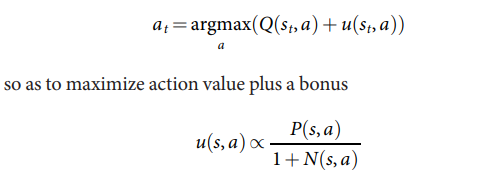
This is just the concept of **USB**, maintain some degree of **exploration** in the improvement  